## **Overview dataset**

Upload the files. You should have something like this:

In [ ]:
!wc -l miniVQA/*.csv

  110 miniVQA/answer_key.csv
  110 miniVQA/sample_submission.csv
  110 miniVQA/test.csv
  780 miniVQA/train.csv
  110 miniVQA/val.csv
 1220 total


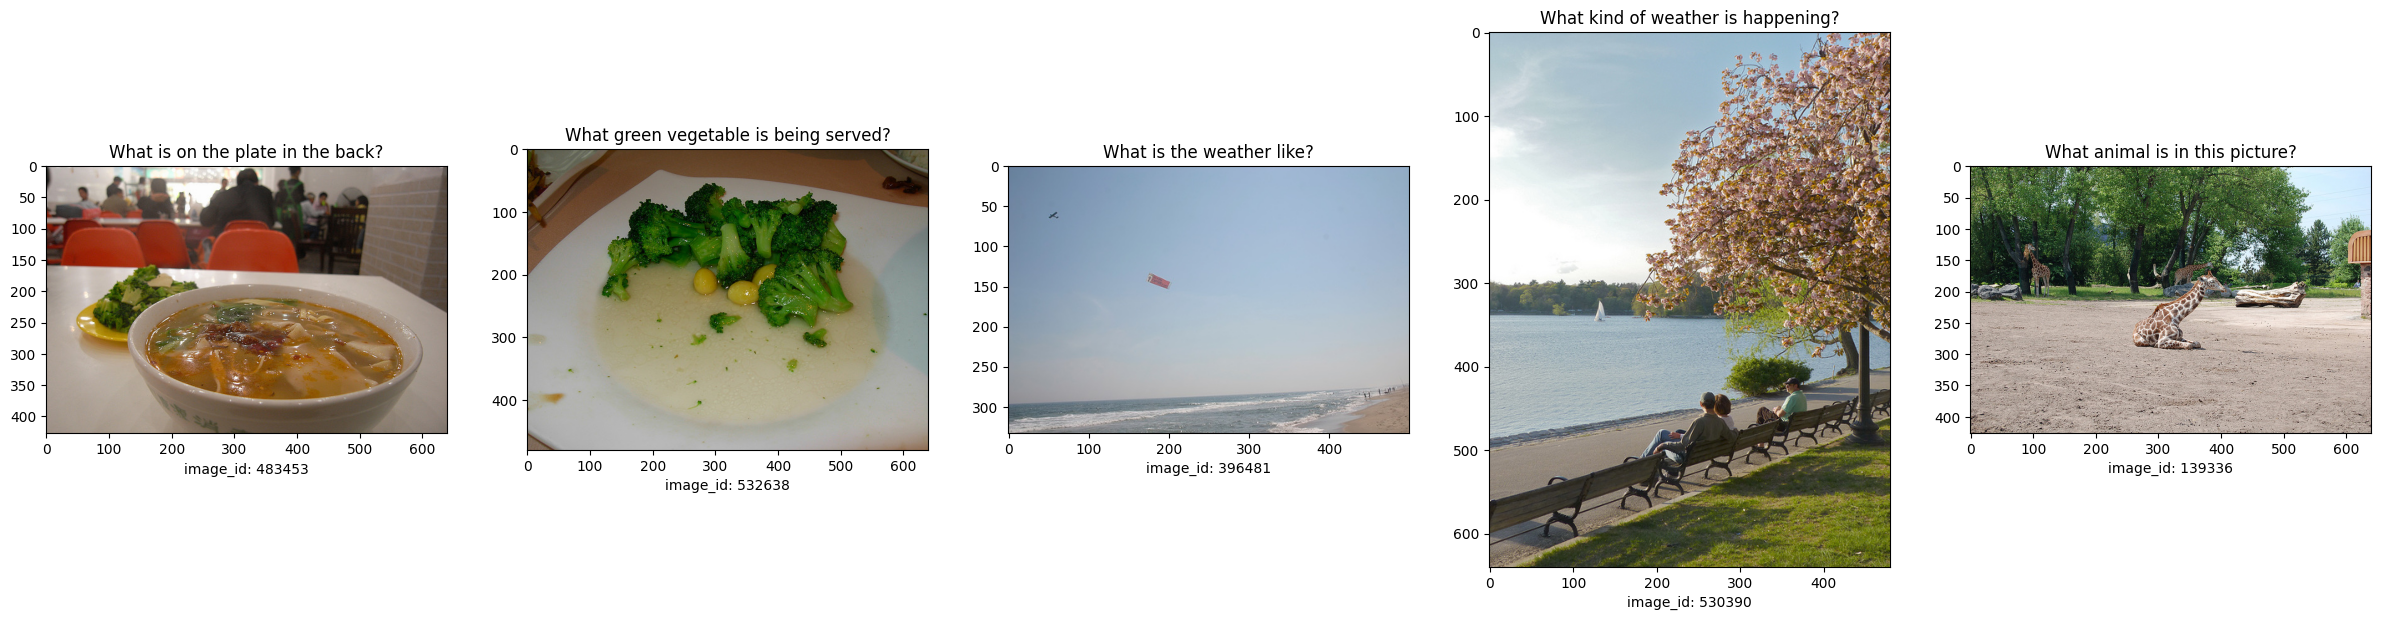

In [ ]:
import json
import random
import matplotlib.pyplot as plt
import cv2
from PIL import Image


import urllib.request
import os
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from tqdm import tqdm

image_question = json.load(open('miniVQA/image_question.json'))
plt.figure(figsize=([30, 20]))
pbar = tqdm(image_question.keys(), position=0, leave=True)
for img in pbar:
  filename = 'COCO_train2014_'+ str(img).zfill(12) + '.jpg'
  pbar.set_description("Downloading image {}".format(filename))
  src = os.path.join('https://vqa_mscoco_images.s3.amazonaws.com/train2014/', filename)
  trg = os.path.join('/tmp', filename)
  if not os.path.exists(trg):
    urllib.request.urlretrieve(src, trg)
for i in range(5):
  plt.subplot(1, 5, i+1)
  random_image = random.choice(list(image_question.keys()))
  _, random_question = random.choice(image_question[random_image])
  filename = 'COCO_train2014_'+ str(random_image).zfill(12) + '.jpg'
  trg = os.path.join('/tmp', filename)
  plt.imshow(Image.open(trg))
  plt.xlabel('image_id: '+random_image)
  plt.title(random_question)

In [ ]:
import torchvision.models as models
import torch
import numpy as np
model_ft = models.resnet18(pretrained=True)
### strip the last layer
feature_extractor = torch.nn.Sequential(*list(model_ft.children())[:-1])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 187MB/s]


In [ ]:
data = {}
for img in list(image_question.keys())[:1]:
  filename = 'COCO_train2014_'+ str(img).zfill(12) + '.jpg'
  pbar.set_description("Downloading image {}".format(filename))
  trg = os.path.join('/tmp', filename)
  img = Image.open(trg)
  img = np.resize(np.asarray(img), (640, 640, 3))
  print(img[:, :, 0])
  img = torch.tensor(np.asarray(img))
  img = img.permute(2, 0, 1)
  print(img.shape)

# print(x, y)

[[81 80 78 ... 70 70 70]
 [79 79 79 ... 70 70 70]
 [77 78 79 ... 68 69 68]
 ...
 [79 80 80 ... 75 72 71]
 [86 86 85 ... 87 87 87]
 [80 77 77 ... 81 79 80]]
torch.Size([3, 640, 640])


## **Sentence Embedding**

In [ ]:
!pip install sentence_transformers

     |████████████████████████████████| 85 kB 2.6 MB/s 
     |████████████████████████████████| 2.8 MB 32.5 MB/s 
     |████████████████████████████████| 1.2 MB 41.3 MB/s 
     |████████████████████████████████| 50 kB 6.5 MB/s 
     |████████████████████████████████| 895 kB 44.8 MB/s 
     |████████████████████████████████| 636 kB 40.3 MB/s 
     |████████████████████████████████| 3.3 MB 39.9 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.0.0-py3-none-any.whl size=126710 sha256=a79393e0b925bc7efbefc85de7f6475bf10ce81153018002daf71bf5e3179747
  Stored in directory: /root/.cache/pip/wheels/d1/c1/0f/faafd427f705c4b012274ba60d9a91d75830306811e1355293
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from sentence_transformers import SentenceTransformer
import time

model = SentenceTransformer('distilbert-base-nli-mean-tokens').cuda()
sentences = 'This framework generates embeddings for each input sentence'
time_start = time.time()
sentence_embeddings = model.encode(sentences)
print(time.time()-time_start)
print(sentence_embeddings.shape)


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

0.21265602111816406
(768,)


# Dataloader

In [ ]:
import torch
import json
import csv
from torch.utils.data import Dataset
from torchvision.transforms import *
from PIL import Image
import os
import numpy as np
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm
import pickle
from google.colab import files

test_transform = transforms.Compose([
            transforms.Resize((112,112)),
            transforms.ToTensor(),
        ])      

train_transform = transforms.Compose([
            transforms.RandomResizedCrop((112,112)),
            transforms.ToTensor(),
        ])      

question_embedder = SentenceTransformer('distilbert-base-nli-mean-tokens').cuda()

class MiniVQA(Dataset):
  def __init__(self, name):
    super(MiniVQA, self).__init__()
    assert name in ["train","val","test"]

    data_csv = csv.DictReader(open('miniVQA/'+name+'.csv'), delimiter=',')
    # Question_id -> label
    self.questionId_label = {int(row['question_id']): row['label'] for row in data_csv}
    # Set of question ids
    self.questionIds = list(self.questionId_label.keys())
    # Num of labels
    self.num_answer = len(set(self.questionId_label.values()))
    # index to label
    self.labels = open("miniVQA/answer_list.txt", "r").read().splitlines()
    # Image to questions
    self.image_question = json.load(open('miniVQA/image_question.json'))

    # Preprocessing
    # We need to have a dict questionId -> (question_embedding, image_id) 
    question_file = "miniVQA/"+name+"_question_embeddings.pkl"
    if os.path.exists(question_file):
      print("Loading ", question_file)
      self.questionId_qi = pickle.load(open(question_file,'rb'))
    else:
      print("Creating ", question_file)
      self.questionId_qi = {}
      for image_id, questions in tqdm(self.image_question.items(), total=len(self.image_question)):
        for q in questions:
          question_id, question = q
          if question_id in self.questionIds:            
            self.questionId_qi[question_id] = (question_embedder.encode(question), image_id)       

      pickle.dump(self.questionId_qi, open(question_file, 'wb'))

    if name == 'train':
      self.transform = train_transform
    else:
      self.transform = test_transform

    self.name = name

  def __len__(self):
    return len(self.questionIds)

  def __getitem__(self, idx):
    id = self.questionIds[idx]
    # Question and image_id
    question_embedding, image_id = self.questionId_qi[id]
    # Image from image_id
    filename = 'COCO_train2014_'+ str(image_id).zfill(12) + '.jpg'
    trg = os.path.join('/tmp', filename)
    img = self.transform(Image.open(trg).convert('RGB'))
    # Label
    if self.name == 'test':
      label = np.array(-1) # bidon
    else:
      label = np.array(self.questionId_label[id], dtype=np.long)

    return id, question_embedding, img, label

test_dataset = MiniVQA("test")
val_dataset = MiniVQA("val")
train_dataset = MiniVQA("train")

# Vérifier le bon nombre de samples 
print("ٔNumber of samples in train split", len(train_dataset))
print("Number of samples in val split", len(val_dataset))
print("Number of samples in test split", len(test_dataset))

training_generator = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_generator = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# for i in tqdm(range(len(train_dataset))):
#   train_dataset.__getitem__(i)

Creating  miniVQA/test_question_embeddings.pkl


  0%|          | 0/836 [00:00<?, ?it/s]

Creating  miniVQA/val_question_embeddings.pkl


  0%|          | 0/836 [00:00<?, ?it/s]

Creating  miniVQA/train_question_embeddings.pkl


  0%|          | 0/836 [00:00<?, ?it/s]

ٔNumber of samples in train split 780
Number of samples in val split 110
Number of samples in test split 110


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# !zip question_embeddings.zip miniVQA/*.pkl

## **Training**

In [ ]:
import torch.optim as optim
import time

def train(net, batch_size=64, learning_rate=1e-3, num_epochs=99999999999, max_early_stop=5):
    loss_func = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=0, factor=0.8)
    early_stop = 0
    best_accuracy = 0.0

    for epoch in range(num_epochs):
      net.train() # nouveau
      epoch_start = time.time()
      for iteration, sample in enumerate(training_generator):
        _, question, img, label = sample
        optimizer.zero_grad()
        out = net(img.cuda(), question.cuda())
        loss = loss_func(out, label.cuda())
        print(label)
        print(out)
        return
        loss.backward()
        optimizer.step()
        
        print("\r[Epoch %2d][Step %4d/%4d] Loss: %.4f, Lr: %.2e, ES: %2d" % (
                        epoch + 1,
                        iteration,
                        int(len(training_generator.dataset) / batch_size),
                        loss.cpu().data.numpy() / batch_size,
                        *[group['lr'] for group in optimizer.param_groups],
                        early_stop,
                    ), end='          ')
        
      epoch_end = time.time() - epoch_start
      net.eval()
      accuracy = []
      val_loss = 0
      for j, sample in enumerate(val_generator):
        _, question, img, label = sample
        out = net(img.cuda(), question.cuda())
        val_loss += loss_func(out, label.cuda()).data.cpu()
        best = np.argmax(out.data.cpu().numpy(), axis=-1)
        accuracy.extend(list(best == label.data.cpu().numpy()))
      
      early_stop += 1
      val_accuracy = np.mean(accuracy)*100
      # Best model found
      if val_accuracy > best_accuracy:
        torch.save(net.state_dict(), 'best_model.pth') 
        best_accuracy = val_accuracy
        early_stop = 0

      print('\n epoch_time', str(epoch_end),
            'val_acc', str(val_accuracy), 
            'val_loss', str(val_loss.item()),
            'best_acc', str(best_accuracy))
      scheduler.step(val_accuracy)

      # No improvements for max_early_stop epochs
      if early_stop == max_early_stop:
        break

    print("Training done, testing")
    soumission = []
    net.load_state_dict(torch.load('best_model.pth'))
    net.eval()
    for j, sample in enumerate(test_generator):
      id, question, img, label = sample
      out = net(img.cuda(), question.cuda())
      best = np.argmax(out.data.cpu().numpy(), axis=-1)
      soumission.append(str(id.item())+','+str(best.item()))
    open('soumission.csv', 'w+').write('question_id,label\n'+'\n'.join(map(str, soumission)))
    files.download('soumission.csv')

In [ ]:
from torchvision.models import ResNet
from torchvision.models.resnet import BasicBlock, Bottleneck
from torchvision.models.utils import load_state_dict_from_url

import torch.nn as nn

class Network(ResNet):
  def __init__(self, block, layers, flatten_size, question_size, pretrained=None):
    super(Network, self).__init__(block, layers)
    if pretrained is not None:
        state_dict = load_state_dict_from_url(pretrained,
                                              progress=True)
        self.load_state_dict(state_dict)

    self.fc = nn.Linear(flatten_size + question_size, train_dataset.num_answer)
    self.dropout = nn.Dropout(p=0.5)

  def forward(self, x, question):

      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.maxpool(x)

      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)
      # print(x.shape)
      # x = self.avgpool(x)
      x = torch.flatten(x, 1)
      x = torch.cat((x,question), 1)
      x = self.dropout(x)
      x = self.fc(x)

      return x

# 57 secondes / epoch 
net = Network(BasicBlock, [2, 2, 2, 2], flatten_size=512*4*4, question_size=768, 
              pretrained="https://download.pytorch.org/models/resnet18-5c106cde.pth")
# 118 secondes / epoch 
# net = Network(Bottleneck, [3, 4, 6, 3], flatten_size=1024, question_size=768)

net.cuda()
train(net, num_epochs=10)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([8, 8, 9, 5, 6, 1, 8, 8, 3, 1, 7, 2, 1, 4, 9, 0, 2, 0, 2, 6, 2, 8, 2, 8,
        1, 8, 3, 6, 8, 6, 5, 2, 1, 9, 8, 6, 9, 7, 6, 7, 2, 9, 9, 8, 7, 9, 2, 1,
        5, 5, 9, 5, 5, 3, 8, 6, 3, 7, 1, 6, 1, 7, 2, 7])
tensor([[ 4.0704e-01, -1.1940e+00, -1.2915e+00, -1.3181e+00, -2.7460e+00,
         -3.8912e+00,  1.1653e+00, -1.4264e+00, -1.2940e+00, -1.0400e+00],
        [-3.3716e-01,  9.8454e-01, -1.2866e+00,  1.5082e+00, -1.6368e+00,
         -6.6155e-01,  1.1161e+00,  1.0375e+00,  5.1401e-01,  1.8717e+00],
        [-3.0804e-01,  1.0284e+00, -1.0902e+00,  1.9361e+00,  1.6020e-01,
         -3.4085e+00,  2.3083e-01, -1.8034e+00,  1.6667e+00, -2.0297e+00],
        [ 4.5741e-01,  2.0467e+00, -7.6143e-01,  1.6664e+00, -9.6375e-01,
         -2.5811e-01,  1.4702e+00,  6.8894e-02, -2.8624e-01,  1.2874e+00],
        [-1.0522e+00,  9.5343e-01, -1.3268e+00, -6.6096e-01, -2.1983e+00,
          2.5597e-01, -1.8042e-02,  6.0751e-01,  7.6663e-01, -2.0596e+00],
        [-9.1037e-01,  4.3358e-01, -9.

In [ ]:
print("Training done, testing")
soumission = []
net.load_state_dict(torch.load('best_model.pth'))
net.eval()
for j, sample in enumerate(test_generator):
  id, question, img, label = sample
  out = net(img.cuda(), question.cuda())
  best = np.argmax(out.data.cpu().numpy(), axis=-1)
  soumission.append(str(id.item())+','+str(best.item()))
open('soumission.csv', 'w+').write('question_id,label\n'+'\n'.join(map(str, soumission)))
files.download('soumission.csv')

Training done, testing


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[Epoch  1][Step  785/ 785] Loss: 0.0359, Lr: 1.00e-03, ES:  0          
 epoch_time 57.24412226676941 val_acc 31.301587301587304 val_loss 227.40809631347656 best_acc 31.301587301587304
 
[Epoch 33][Step  785/ 785] Loss: 0.0283, Lr: 6.87e-05, ES:  0          
 epoch_time 57.55292344093323 val_acc 43.42857142857143 val_loss 178.32003784179688 best_acc 43.57142857142857